## Importación de librerías

In [119]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import randoms

## Carga de datasets

In [120]:
def load_dataset(folder_path):
    dataset = []
    for tag in os.listdir(folder_path):
        tag_path = os.path.join(folder_path, tag)
        if os.path.isdir(tag_path):
            for filename in os.listdir(tag_path):
                image_path = os.path.join(tag_path, filename)
                image = Image.open(image_path)
                image = image.resize((150,150))
                image = np.array(image)
                dataset.append((image, tag))

    random.shuffle(dataset)
    return dataset

In [121]:
train_dataset = load_dataset('seg_train/seg_train')
test_dataset = load_dataset('seg_test/seg_test')

In [122]:
path = "seg_pred/seg_pred"
# Lista para almacenar las imágenes cargadas
imagenes = []

# Enumerar los archivos en la carpeta
for archivo in os.listdir(path):
    if archivo.endswith(".jpg") or archivo.endswith(".jpeg") or archivo.endswith(".png"):
        ruta_archivo = os.path.join(path, archivo)
        image = Image.open(ruta_archivo)
        image = image.resize((150,150))
        image = np.array(image)
        imagenes.append(image)

# Convertir la lista de imágenes a un array NumPy
pred_dataset = np.array(imagenes)
random.shuffle(pred_dataset)

## Preprocesamiento de datos

In [123]:
def procesar_dataset(dataset):
    # Obtener el número total de imágenes en el dataset
    num_images = len(dataset)
    print("Número total de imágenes:", num_images)

    # Obtener el número de clases únicas en el dataset
    classes = set([entry[1] for entry in dataset])
    num_classes = len(classes)
    print("Número de clases únicas:", num_classes)

    # Imprimir las clases únicas
    print("Clases únicas:", classes)

    # Mostrar algunas imágenes aleatorias del dataset
    num_samples = 5
    random_samples = random.sample(dataset, num_samples)

    plt.figure(figsize=(15, 3))

    for i, (image, tag) in enumerate(random_samples):
        # Comprobar si la imagen se cargó correctamente
        if isinstance(image, (Image.Image, np.ndarray)):
            # Mostrar la imagen si se cargó correctamente
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image)
            plt.title(tag)
            plt.axis("off")
        else:
            print(f"La imagen {image} no se cargó correctamente.")

    plt.show()

Número total de imágenes: 14034
Número de clases únicas: 6
Clases únicas: {'glacier', 'street', 'sea', 'mountain', 'forest', 'buildings'}


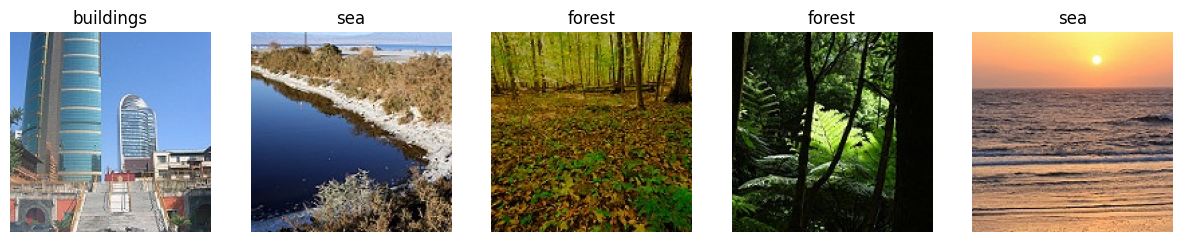

In [124]:
procesar_dataset(train_dataset)

Número total de imágenes: 3000
Número de clases únicas: 6
Clases únicas: {'glacier', 'street', 'sea', 'mountain', 'forest', 'buildings'}


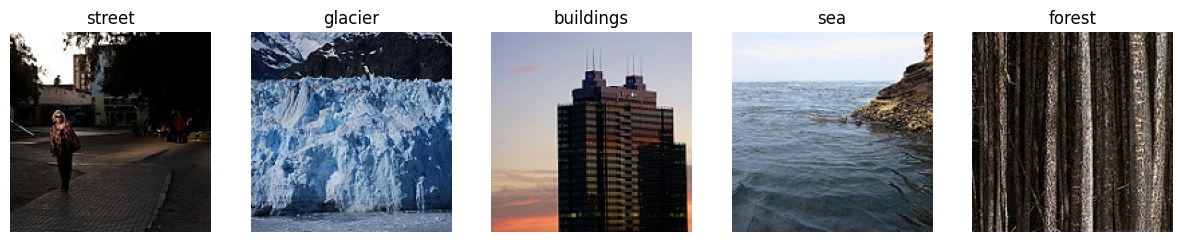

In [125]:
procesar_dataset(test_dataset)

In [126]:
etiquetas_unicas = set([entry[1] for entry in train_dataset])

etiquetas_aleatorias = list(etiquetas_unicas)
random.shuffle(etiquetas_aleatorias)

tags_dict = {tag: i for i, tag in enumerate(etiquetas_aleatorias)}
print("Diccionario de etiquetas:", tags_dict)

train_images = np.array([entry[0] for entry in train_dataset])
train_tags = np.array([tags_dict[entry[1]] for entry in train_dataset])

test_images = np.array([entry[0] for entry in test_dataset])
test_tags = np.array([tags_dict[entry[1]] for entry in test_dataset])

Diccionario de etiquetas: {'buildings': 0, 'mountain': 1, 'street': 2, 'forest': 3, 'glacier': 4, 'sea': 5}


In [127]:
def test_model(model):
    model.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

    model.fit(train_images, train_tags, epochs=20)

    test_loss, test_acc = model.evaluate(test_images, test_tags, verbose=2)

    print('\nTest accuracy:', test_acc)

def prediction_distribution(model, images):
    predicciones = model.predict(images)
    etiquetas_predichas = np.argmax(predicciones, axis=1)
    distribucion_predicciones = np.bincount(etiquetas_predichas, minlength=len(tags_dict))

    nombres_clases = [list(tags_dict.keys())[i] for i in range(len(tags_dict))]

    plt.bar(nombres_clases, distribucion_predicciones)
    plt.xlabel('Tag')
    plt.ylabel('Cantidad de predicciones')
    plt.title('Distribución de predicciones del modelo')
    plt.xticks(rotation=45)
    plt.show()

## Dense Model

Epoch 1/20
439/439 [==============================] - 3s 5ms/step - loss: 1345.4050 - accuracy: 0.3399
Epoch 2/20
439/439 [==============================] - 2s 5ms/step - loss: 138.2538 - accuracy: 0.4136
Epoch 3/20
439/439 [==============================] - 2s 5ms/step - loss: 61.9104 - accuracy: 0.4153
Epoch 4/20
439/439 [==============================] - 2s 5ms/step - loss: 33.1982 - accuracy: 0.3806
Epoch 5/20
439/439 [==============================] - 2s 4ms/step - loss: 9.7520 - accuracy: 0.4503
Epoch 6/20
439/439 [==============================] - 2s 4ms/step - loss: 9.7989 - accuracy: 0.4213
Epoch 7/20
439/439 [==============================] - 2s 4ms/step - loss: 4.5120 - accuracy: 0.4498
Epoch 8/20
439/439 [==============================] - 2s 4ms/step - loss: 2.6538 - accuracy: 0.4788
Epoch 9/20
439/439 [==============================] - 2s 4ms/step - loss: 1.8540 - accuracy: 0.4706
Epoch 10/20
439/439 [==============================] - 2s 4ms/step - loss: 2.3304 - accuracy:

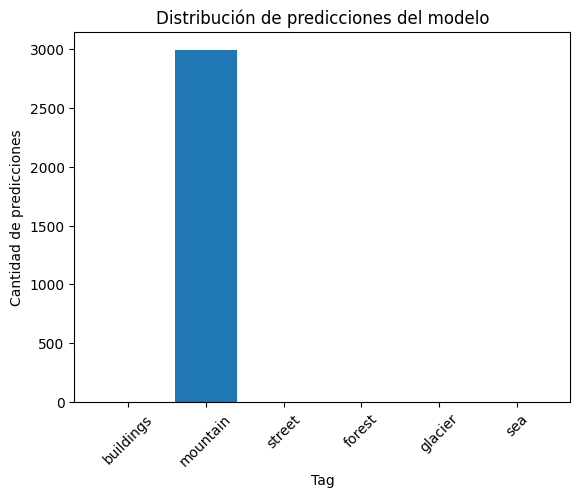

In [128]:
DenseModel = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(150, 150, 3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6)
])

test_model(DenseModel)

prediction_distribution(DenseModel, test_images)

## Convolutional Model

Epoch 1/20
439/439 [==============================] - 5s 11ms/step - loss: 9.2727 - accuracy: 0.2473
Epoch 2/20
439/439 [==============================] - 4s 10ms/step - loss: 1.7546 - accuracy: 0.2362
Epoch 3/20
439/439 [==============================] - 4s 9ms/step - loss: 1.7148 - accuracy: 0.2591
Epoch 4/20
439/439 [==============================] - 4s 9ms/step - loss: 1.6053 - accuracy: 0.3245
Epoch 5/20
439/439 [==============================] - 4s 10ms/step - loss: 1.5800 - accuracy: 0.3469
Epoch 6/20
439/439 [==============================] - 4s 10ms/step - loss: 1.4593 - accuracy: 0.4008
Epoch 7/20
439/439 [==============================] - 4s 10ms/step - loss: 1.2211 - accuracy: 0.5090
Epoch 8/20
439/439 [==============================] - 4s 10ms/step - loss: 0.9076 - accuracy: 0.6446
Epoch 9/20
439/439 [==============================] - 4s 10ms/step - loss: 0.6795 - accuracy: 0.7332
Epoch 10/20
439/439 [==============================] - 4s 10ms/step - loss: 0.5445 - accuracy

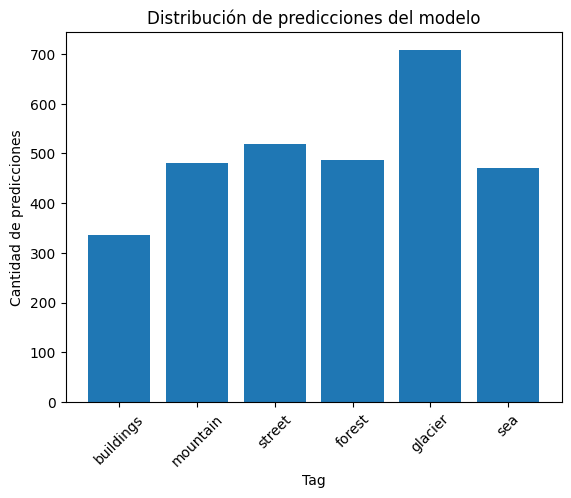

In [129]:
ConvolutionalModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6)
])

test_model(ConvolutionalModel)

prediction_distribution(ConvolutionalModel, test_images)

## ResNet Model

Epoch 1/20
439/439 [==============================] - 12s 20ms/step - loss: 0.3754 - accuracy: 0.8700
Epoch 2/20
439/439 [==============================] - 9s 19ms/step - loss: 0.2421 - accuracy: 0.9139
Epoch 3/20
439/439 [==============================] - 9s 20ms/step - loss: 0.2125 - accuracy: 0.9232
Epoch 4/20
439/439 [==============================] - 9s 21ms/step - loss: 0.1851 - accuracy: 0.9344
Epoch 5/20
439/439 [==============================] - 9s 20ms/step - loss: 0.1652 - accuracy: 0.9401
Epoch 6/20
439/439 [==============================] - 9s 20ms/step - loss: 0.1506 - accuracy: 0.9461
Epoch 7/20
439/439 [==============================] - 9s 20ms/step - loss: 0.1354 - accuracy: 0.9506
Epoch 8/20
439/439 [==============================] - 9s 20ms/step - loss: 0.1260 - accuracy: 0.9546
Epoch 9/20
439/439 [==============================] - 9s 20ms/step - loss: 0.1212 - accuracy: 0.9562
Epoch 10/20
439/439 [==============================] - 9s 20ms/step - loss: 0.1107 - accur

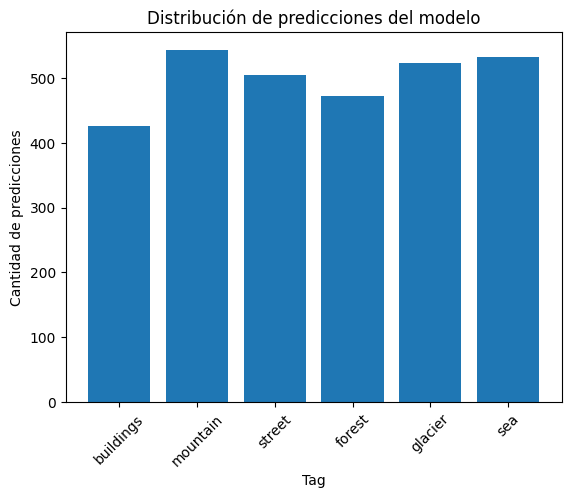

In [148]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3)
)

model.trainable = False

ResNetModel = tf.keras.models.Sequential([
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6)
])

test_model(ResNetModel)
prediction_distribution(ResNetModel, test_images)